In [1]:
from bs4 import BeautifulSoup    # HTML PARSER
from selenium import webdriver   # JS LOADER
import sqlite3 as slt            # DATABASE
import os                        # SYSTEM FUNCTIONS
import re                        # REGULAR EXPRESSION

path = os.getcwd()               # Create a path reference

In [2]:
db_filepath = os.path.join(path , "database.db") # Path to database file
conn = slt.connect(db_filepath)                  # Creating database 
                                                 # and opening connection
cursor = conn.cursor()                           # Opening a cursor

# Let's create our tables
qry = 'CREATE TABLE IF NOT EXISTS TBL_PRODUCTS (KIND TEXT, ID INTEGER, NAME TEXT, LINK TEXT, PRICE_ORIG REAL, PRICE_CURR REAL, PRICE_INST REAL , NUM_INST TEXT, SAVINGS REAL, RATING TEXT, BRAND TEXT, STATUS TEXT, PROMOTION TEXT, AVAILABILITY TEXT , INTEREST TEXT)'
cursor.execute("DROP TABLE TBL_PRODUCTS")
cursor.execute(qry)                             # Executing DDL command

In [3]:
rifle_url = 'https://www.ventureshop.com.br/rifles-airsoft-s223/'

In [4]:
# Here i'm using Safari
# You can choose the driver (Browse)
# That best suits you

browser = webdriver.Safari()       # Initialize browser
browser.get(rifle_url)                # rendering content
html = browser.page_source      # retrieving DOM

soup = BeautifulSoup(html, 'lxml')    # initilize soup object with html content

In [5]:
page_content = soup.find_all("ul" , {'class','products'})

In [6]:

# Function to retrieve product name
def getProductName(item):
    product_div = item.find('div',{'class':'product-name'})
    product_name = product_div.text
    return {'NAME':product_name}

# Function to retrieve product rating
def getRating(item):
    spans = item.find_all('span')
    for span in spans:
        classes = span.attrs['class']
        if 'rating' in classes:
            for value in classes:
                m = re.search("rate" , value)
                if m:
                    return {'RATING':value}
    # We are assuming that, when there is no rating... 
    # is because the product is new. 
    # So, let's give an initial rate (rate-new)
    # Avoid bias your insights (don't mix things)
    return {'RATING':'rate-new'} 

# Function to retrieve product prices
def getPrices(item):
    prices = dict()
    
    # Current Price
    try:        
        _price = item.find('div',{'class':'price'})
        _price = _price.find('del')
        _price = _price.find('b')
        prices['PRICE_ORIG'] = float(_price.text.replace('R$ ','').replace('.','').replace(',','.'))
    except:
        pass
    
    # Current Price
    try:
        _price = item.find('em',{'class':'sale-price'})
        _price = _price.find('b',{'class':'sale'})
        prices['PRICE_CURR'] = float(_price.text.replace('R$ ','').replace('.','').replace(',','.'))
    except:
        pass
    
    # Savings
    try:        
        _price = item.find('small',{'class':'savings'})
        _price = _price.find('b')
        prices['SAVINGS'] = float(_price.text.replace('R$ ','').replace('.','').replace(',','.'))
    except:
        pass

    # Installments
    try:
        _price = item.find('dfn' , {'class':'condition'})
        _n_parcels = _price.find('b' , {'class':'parcels'})
        _parcels = _price.find('b' , {'class':'parcel-value'})
        _interest = _price.find('span' , {'class':'no-interest'})
        prices['PRICE_INST'] = float(_parcels.text.replace('R$ ','').replace('.','').replace(',','.'))
        prices['NUM_INST'] = _n_parcels.text
        prices['INTEREST'] = _interest.text.lstrip()
    except:
        pass

    return prices
    
# Function to retrieve product Brand
def getBrand(item):
    _brand = item.find('div',{'class':'more-sections'})
    _brand = _brand.find('span' , {'class':'brand'})
    return {'BRAND':_brand.text} 
    

# Function to check product availability
def checkAvailability(item):
    _avail = item.find('div' , {'class':'buttons'})
    _avail = _avail.find('a' , {'class':'buy'})
    if _avail:
        return {"AVAILABILITY":"Yes"}
    else:
        return {"AVAILABILITY":"No"}
    
# Funstion to get Promotion info
def getPromotion(item):
    _item = item.find('span' , {'class':'promotion'})
    if _item:
        return {"PROMOTION":"Yes"}
    else:
        return {"PROMOTION":"No"}

In [7]:
# Prepare statement for insertion
def statement(maps):
    cols = maps.keys()
    cols = tuple(cols.__iter__())
    vals = final.values()
    vals = tuple(vals.__iter__())

    qry = 'INSERT INTO TBL_PRODUCTS {cols}'
    qry = qry.format(cols=cols).replace("'","")
    qry += "VALUES {vals}".format(vals=vals)
    return qry

for ul in page_content:                              # Itarare over an <ul>
    for item in ul.find_all('li'):                   # Iterate over a <li>
        if 'break' not in item.attrs['class']:       # Ignoring list breaks
            d1 = getProductName(item)
            d2 = getRating(item)
            d3 = getPrices(item)
            d4 = getBrand(item)
            d5 = checkAvailability(item)
            d6 = getPromotion(item)
            final = {**d1 , **d2 , **d3 , **d4 , **d5 , **d6 }
            
            insert = statement(final)                # Prepare Insert statement
            try:
                cursor.execute(insert)
            except:
                print(d1)
                raise           

In [8]:
import pandas as pd

qry = "SELECT * FROM TBL_PRODUCTS"

dataframe = pd.io.sql.read_sql( qry , conn)

print(dataframe.shape)

(24, 15)


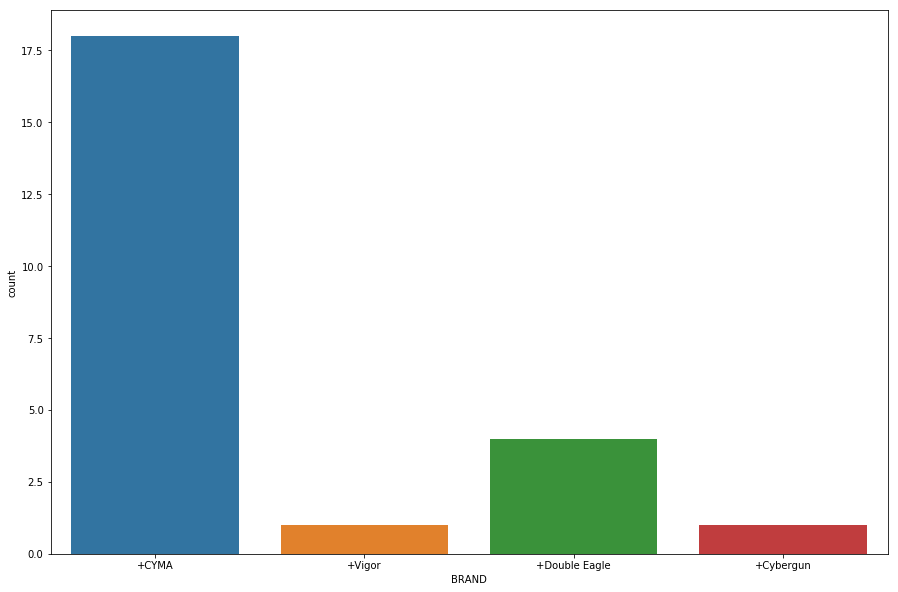

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.subplots(figsize=(15,10))
sns.countplot(data=dataframe , x='BRAND')

In [10]:
dataframe.sort_values(by='PRICE_CURR' , ascending=False).head(3)[['NAME','PRICE_CURR']].values

array([['Rifle de Airsoft AEG Scar Labs CM067 Cyma + Pistola Airsoft 24/7 CO2 Cybergun',
        1599.0],
       ['Rifle de Airsoft AEG M4A1 Custom CM619A - CYMA', 1429.0],
       ["Rifle de Airsoft AEG M4A1 CM518 Black CYMA + Capa + BB's",
        1359.0]], dtype=object)